# Titanic: Machine Learning from Disaster

Here we explore the famous [Titanic data set from Kaggle](https://www.kaggle.com/c/titanic/data) and predict whether a passenger would survive or not. 
Let's start by importing some binaries. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
test = pd.read_csv("./Data/test.csv")
train = pd.read_csv("./Data/train.csv", index_col=0)
train.info()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


There are a total of 11 columns with 891 rows. Following observations can be made just by looking the the output above. 
1. Intuition tell us that the 'Pclass', 'Age', 'Sex', 'Fare' would be few of the factors that decide 'Survived' status.
2. 'Age', 'Cabin' and 'Embarked' have null values. 

Now lets analyse numerical features. 

In [4]:
print (train.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


Following observations can be made : 
1. 38% of the passengers in the data survived as compared to actual 32%. That means we have a slightly biased data, so we will ignore that. 
2. More than 50 % of the passengers were in 'Pclass'=3.
3. Average 'Age' of passengers was 29 with max 'Age' being 80. 
4. Around 70% passengers didn't have any siblings or spuse('SibSp'). 
5. Less than 25% of passenger were with their parents/children('Parch')
6. 'Fare' has a very high standard deviation and the max value of 512 shows presence of outliers. 

Lets analyse our non-numerical features. 

In [23]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Andersson, Miss. Erna Alexandra",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


1. Some 'Ticket'number are alloted to multiple passengers, so we need do adjust the 'Fare' of such tickets accoringly. 
2. 577(64.7%) passengers were male. 
3. 'Cabin' was also shared. 

### Correlating features amongst each other

#### 'Sex' and 'Survived'

In [28]:
# Gender and survived. 
train.loc[:,['Sex','Survived']].groupby(by=['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


74% of females survived as compared to 18% of males. So 'Sex' seems to be a deciding feature.

#### 'Embarked' and 'Survived' 

In [7]:
train.loc[:,['Embarked','Survived']].groupby(by=['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


#### 'Pclass' and 'Survived'

In [6]:
train.loc[:,['Pclass','Survived']].groupby(by=['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


62% of Pclass'=1 survived, while only 24% passengers of 'Pclass'=3 survived. Thus 'Pclass' is also an important feature. 

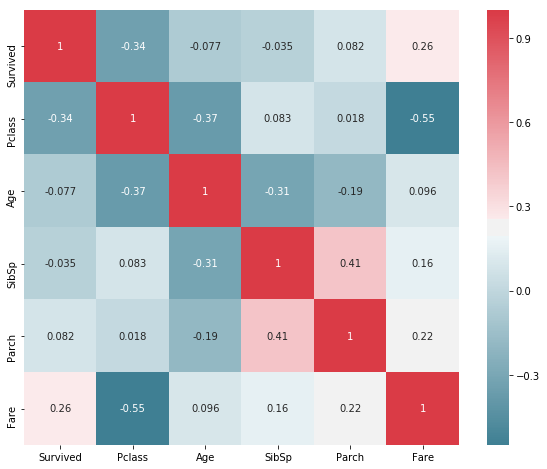

In [13]:
# Lets first plot a correlation matrix. 

f, ax = plt.subplots(figsize=(10,8))
corr = train.corr()
_= sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
# This gives us a sense of importance of features. 
